## CIVENG 263H - Final Project Code
### Archetypal Analysis
#### Deadline: 12/13/2023
#### Team: Erin Jones, Breitling Snyder, Jon Atkins, Balaji Balagesenan

In [67]:
# Imports
import archetypes as arch
from sklearn.datasets import load_iris
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [68]:
# Import cleaned and scaled data
data_w_fips = pd.read_csv('./data/scaled_df.csv')

# Drop numerical fips column or arhcetypes will include this dimension -- future work, it might be interesting to see if states cluster as this is a numerical representation of that to some degree
data_wo_fips = data_w_fips.drop(columns='fips5')

# Create an array -- aa package does not accept df
D = data_wo_fips.to_numpy()

# Snag 'target' for later data viz
target = data_wo_fips['emissions_per_cap'].tolist()

#### Determine number of archetypes

The cell below increases with time exponentially as # of archetypes increase. Hyperparameters were not really tuned and this could be added to future works. The goal of this process is to create a dictionary holding RSS values, which will allow for the creation of a scree plot. RSS replaces the 'entropy' which is used when running the elbow method on k-means.

Future work - The computation of each archetype split into two blocks to ensure jupyter does not time out or label the cell idle and throttle processing. Or the process could be multithreaded and run in the cloud.

Limitation - We were only able to collect up to 14 archetypes and there is not a distinct elbow, which means we may want to do some further dimensionality reduction

In [15]:
# Nearly an hour to run on my 32 GB M2 Max MacbookPro
rss_dict = {}

for i in range(1, 14):
    model = arch.AA(n_archetypes=i, n_init=10, max_iter=10_000, tol=1e-16, random_state=42)
    model.fit(D)
    rss_dict[i] = model.rss_


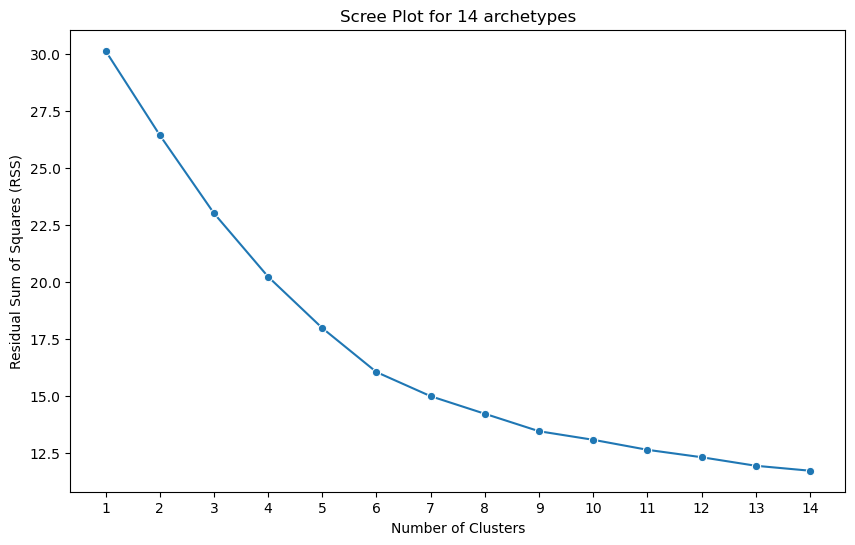

In [20]:
# Converting the dictionary to a Pandas DataFrame
df = pd.DataFrame(list(rss_dict.items()), columns=['Number of Clusters', 'RSS'])

# Creating the scree plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Number of Clusters', y='RSS', data=df, marker='o')
plt.title('Scree Plot for 14 archetypes')
plt.xlabel('Number of Clusters')
plt.ylabel('Residual Sum of Squares (RSS)')
plt.xticks(list(rss_dict.keys()))  # Ensure all cluster numbers are shown
plt.show()

### Initial Result

While there is not a significant elbow in the plot above, we decided to further investigate the results at 6 archetypes and see if we can visually perform a dimensionality reduction based on the archetypes output

#### 6 Archetypes

In [69]:
# Train Model with 6 Archetypes
model = arch.AA(n_archetypes=6, n_init=10, max_iter=10_000, tol=1e-16, random_state=0)
model.fit(D)

# build DF of resulting archetypes
arch_df_6 = pd.DataFrame(model.archetypes_, columns=data_wo_fips.columns)

In [123]:
def plot_vertical_archetypes_bar(archetypes_df):
    # melt df for plotting
    archetypes_df['Archetype'] = archetypes_df.index
    melted = archetypes_df.melt(id_vars='Archetype', var_name='Feature', value_name='Value')
    melted['Value'] = melted['Value'].astype(float)
    # plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Archetype', y='Value', hue='Feature', data=melted)
    plt.title('Archetype Makeup')
    plt.legend(loc='best')
    return plt.show()

def plot_horizontal_archetypes_bar(archetypes_df, n_archetypes):
    # melt df for plotting
    archetypes_df['Archetype'] = archetypes_df.index
    melted = archetypes_df.melt(id_vars='Archetype', var_name='Feature', value_name='Value')
    melted['Value'] = melted['Value'].astype(float)

    # subset df by archetype + add to dict
    subset_dict = {}
    for i in range(n_archetypes):
        subset_dict[i] = melted[melted['Archetype'] == i] 

    # Creating a figure with 3 subplots
    fig, axs = plt.subplots(n_archetypes, 1, figsize=((12*n_archetypes), 50))

    color_list = ['brown', 'coral', 'gold', 'olivedrab', 'mediumseagreen', 'darkturquoise', 'plum']

    for n_arch, subset in subset_dict.items():
        axs[n_arch].bar(subset['Feature'], subset['Value'], color = color_list[n_arch])
        axs[n_arch].set_title(f'Archetype {n_arch}', fontsize=30)
        axs[n_arch].tick_params(axis='x', labelsize=25, rotation=30)
        axs[n_arch].tick_params(axis='y', labelsize=20)
        
    plt.tight_layout()
    return plt.show()


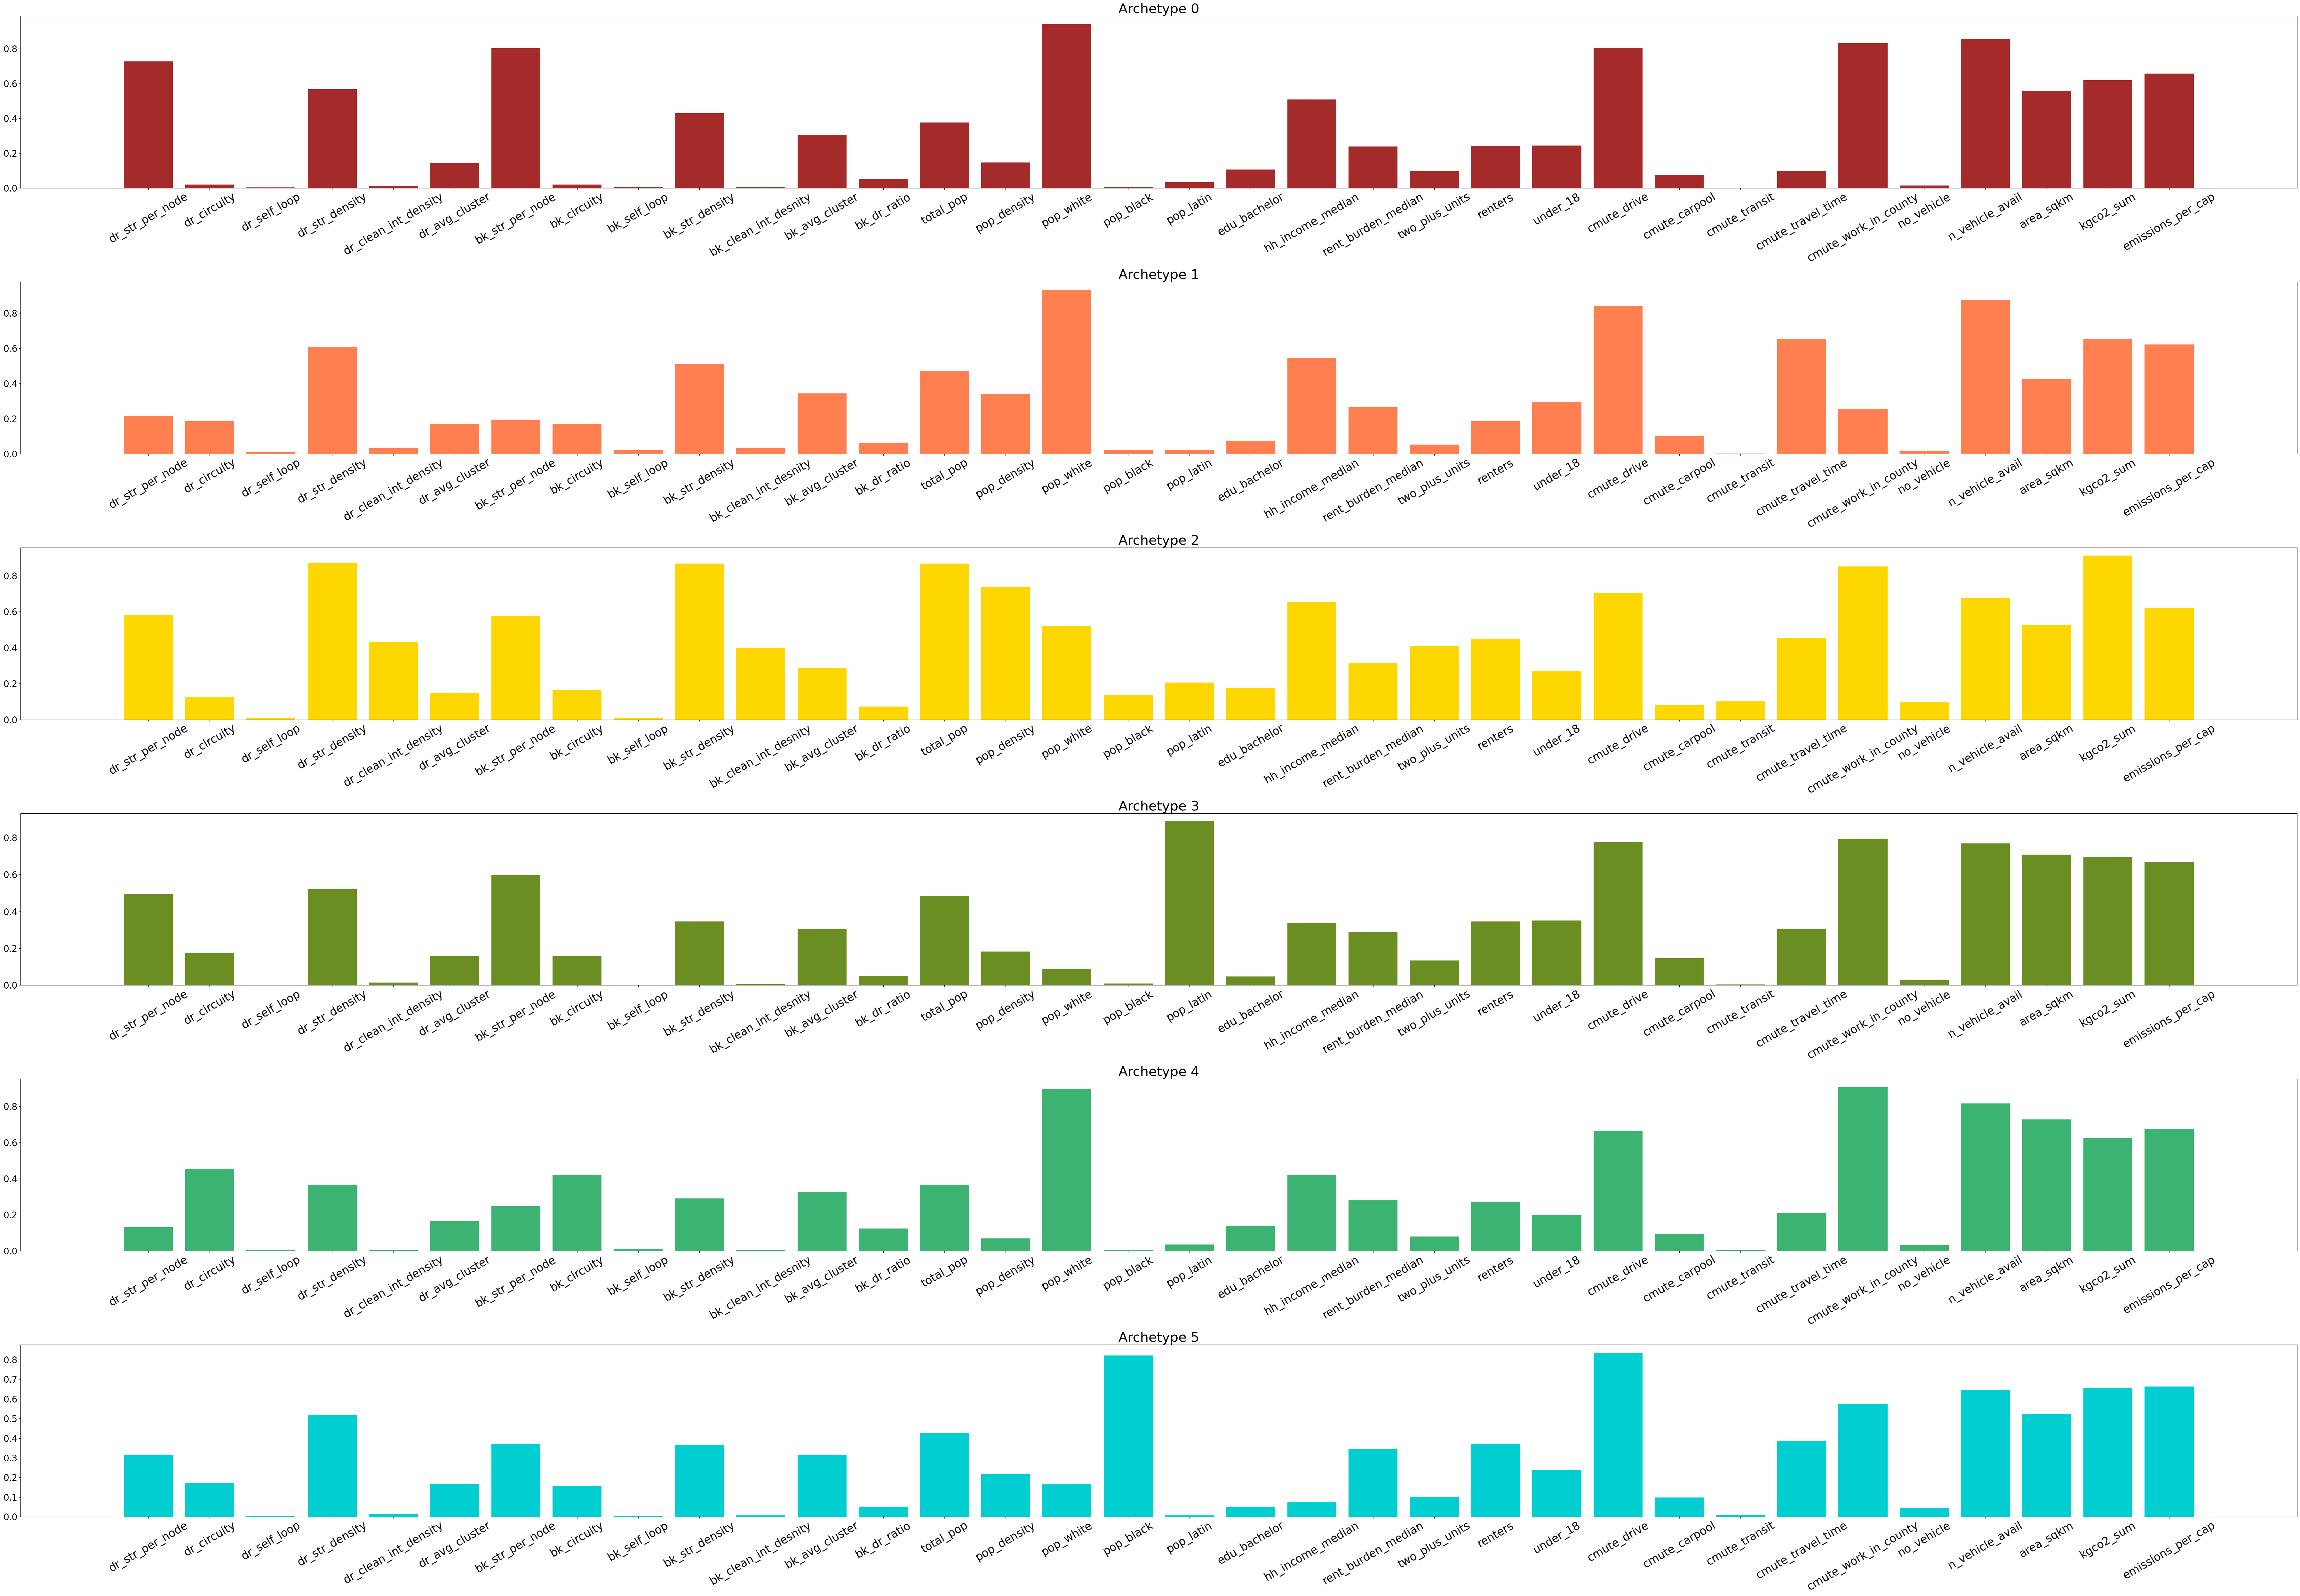

In [124]:
plot_horizontal_archetypes_bar(arch_df_6, 6)

If you save the plot and open it in a new tab that allows you to zoom, you can better see the results. However, we went through and identified the following features are being largely static across the 6 archetypes in an effort to reduce the dimensionality of the dataset visually by selecting features with the highest amount of variance across archetypes.

* dr_self_loop
* dr_avg_cluster
* bk_self_loop
* bk_avg_cluster
* total_pop
* rent_burden_median
* renters
* under_18
* cmute_drive
* emissions_per_cap
* n_vehicle_avail

So we drop and run the analysis again -- our goal is 3 archetypes as it produces a nice simplex visualization, but we will just see the outcome

In [59]:
# Drop numerical fips column or arhcetypes will include this dimension -- future work, it might be interesting to see if states cluster as this is a numerical representation of that to some degree
reduced_df = data_wo_fips.drop(columns=['dr_self_loop', 
                                         'dr_avg_cluster',
                                         'bk_self_loop',
                                         'bk_avg_cluster',
                                         'total_pop', 
                                         'rent_burden_median', 
                                         'renters', 
                                         'under_18', 
                                         'cmute_drive', 
                                         'emissions_per_cap', 
                                         'n_vehicle_avail'])

# Create an array -- aa package does not accept df
r_D = reduced_df.to_numpy()

rss_dict = {}

for i in range(1, 10):
    model = arch.AA(n_archetypes=i, n_init=10, max_iter=10_000, tol=1e-16, random_state=42)
    model.fit(r_D)
    rss_dict[i] = model.rss_

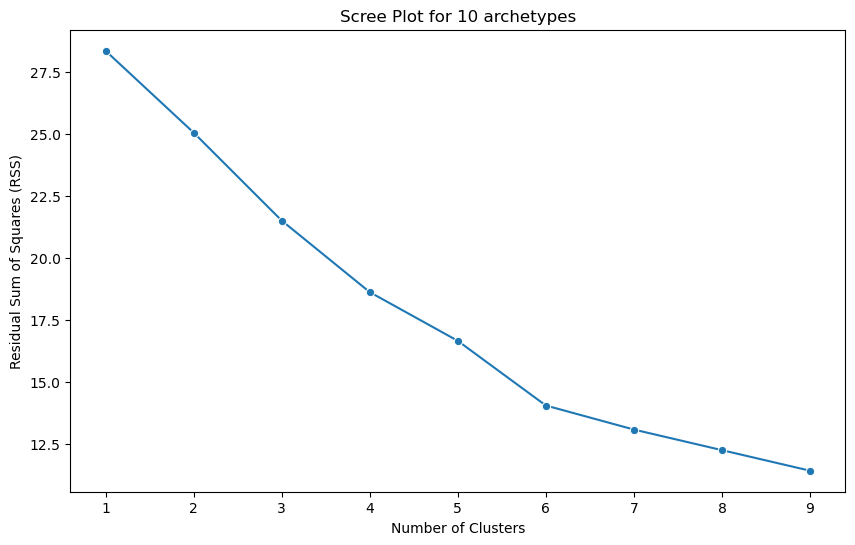

In [60]:
# Converting the dictionary to a Pandas DataFrame
df = pd.DataFrame(list(rss_dict.items()), columns=['Number of Clusters', 'RSS'])

# Creating the scree plot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Number of Clusters', y='RSS', data=df, marker='o')
plt.title('Scree Plot for 10 archetypes')
plt.xlabel('Number of Clusters')
plt.ylabel('Residual Sum of Squares (RSS)')
plt.xticks(list(rss_dict.keys()))  # Ensure all cluster numbers are shown
plt.show()

A weird bulge occurs around five, which may be the result of our visual dimensionality reduction which just eliminated features, however we are seeing a more pronounced elbow in the plot around 6 archetypes. As such we seek to run and plot the six archetypes again with our reduced dataset.

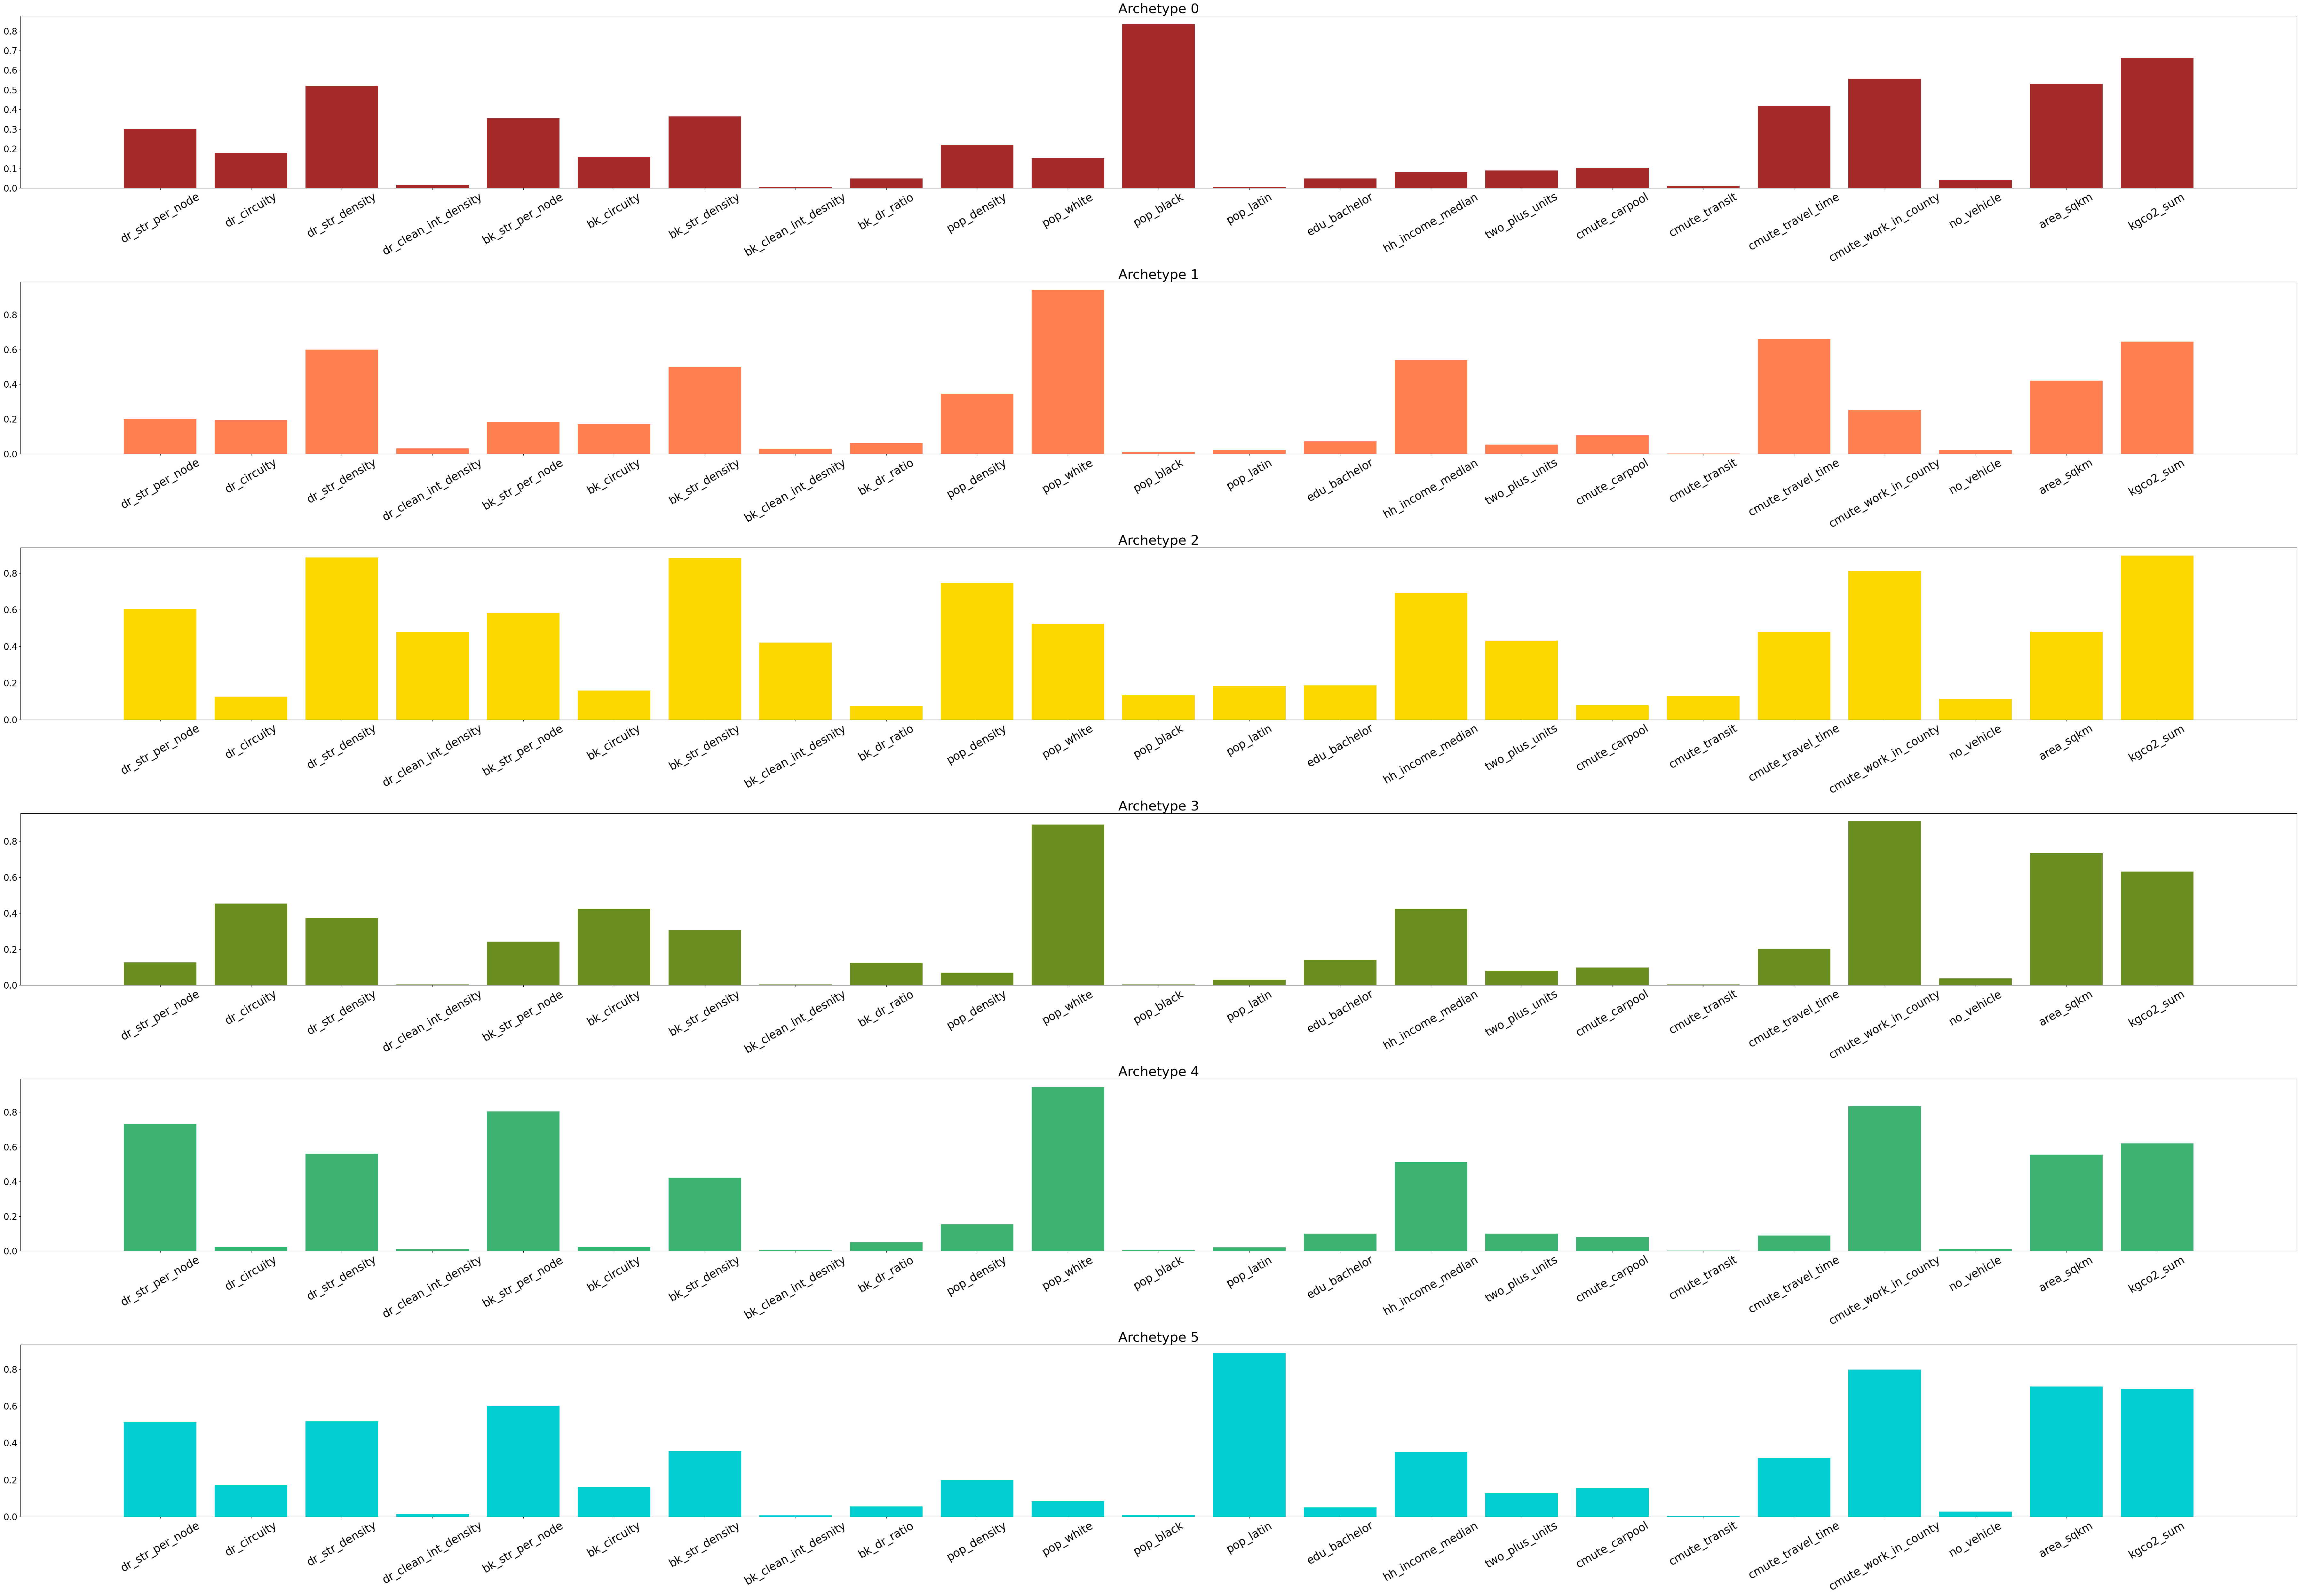

In [125]:
# Train Model with 6 Archetypes
model = arch.AA(n_archetypes=6, n_init=10, max_iter=10_000, tol=1e-16, random_state=0)
model.fit(r_D)

# build DF of resulting archetypes
arch_df_6_new = pd.DataFrame(model.archetypes_, columns=reduced_df.columns)
plot_horizontal_archetypes_bar(arch_df_6_new, 6)

Out of curiousity - we then ran this same model, condensing the model to three archetypes for the purposes of plotting via simplex and analyzing the results. The simplex can be interpreted by examining the presence of points (each point representing a county) clustering at the point of a triangle corresponds to the distinctness with which the archetype at that point represents those datapoints. Ideally, you want to see the clustering towards the points and a clearness of the center of the triangle, which indicates there are fewer points that are equally described by an equal linear combination of all three archetypes.

I also stripped the following features:
* bk_dr_ratio
* bk_str_density
* bk_str_per_node
* edu_bachelor
* hh_income_median
* cmute_carpool
* cmute_work_in_county
* no_vehicle
* area_sqkm

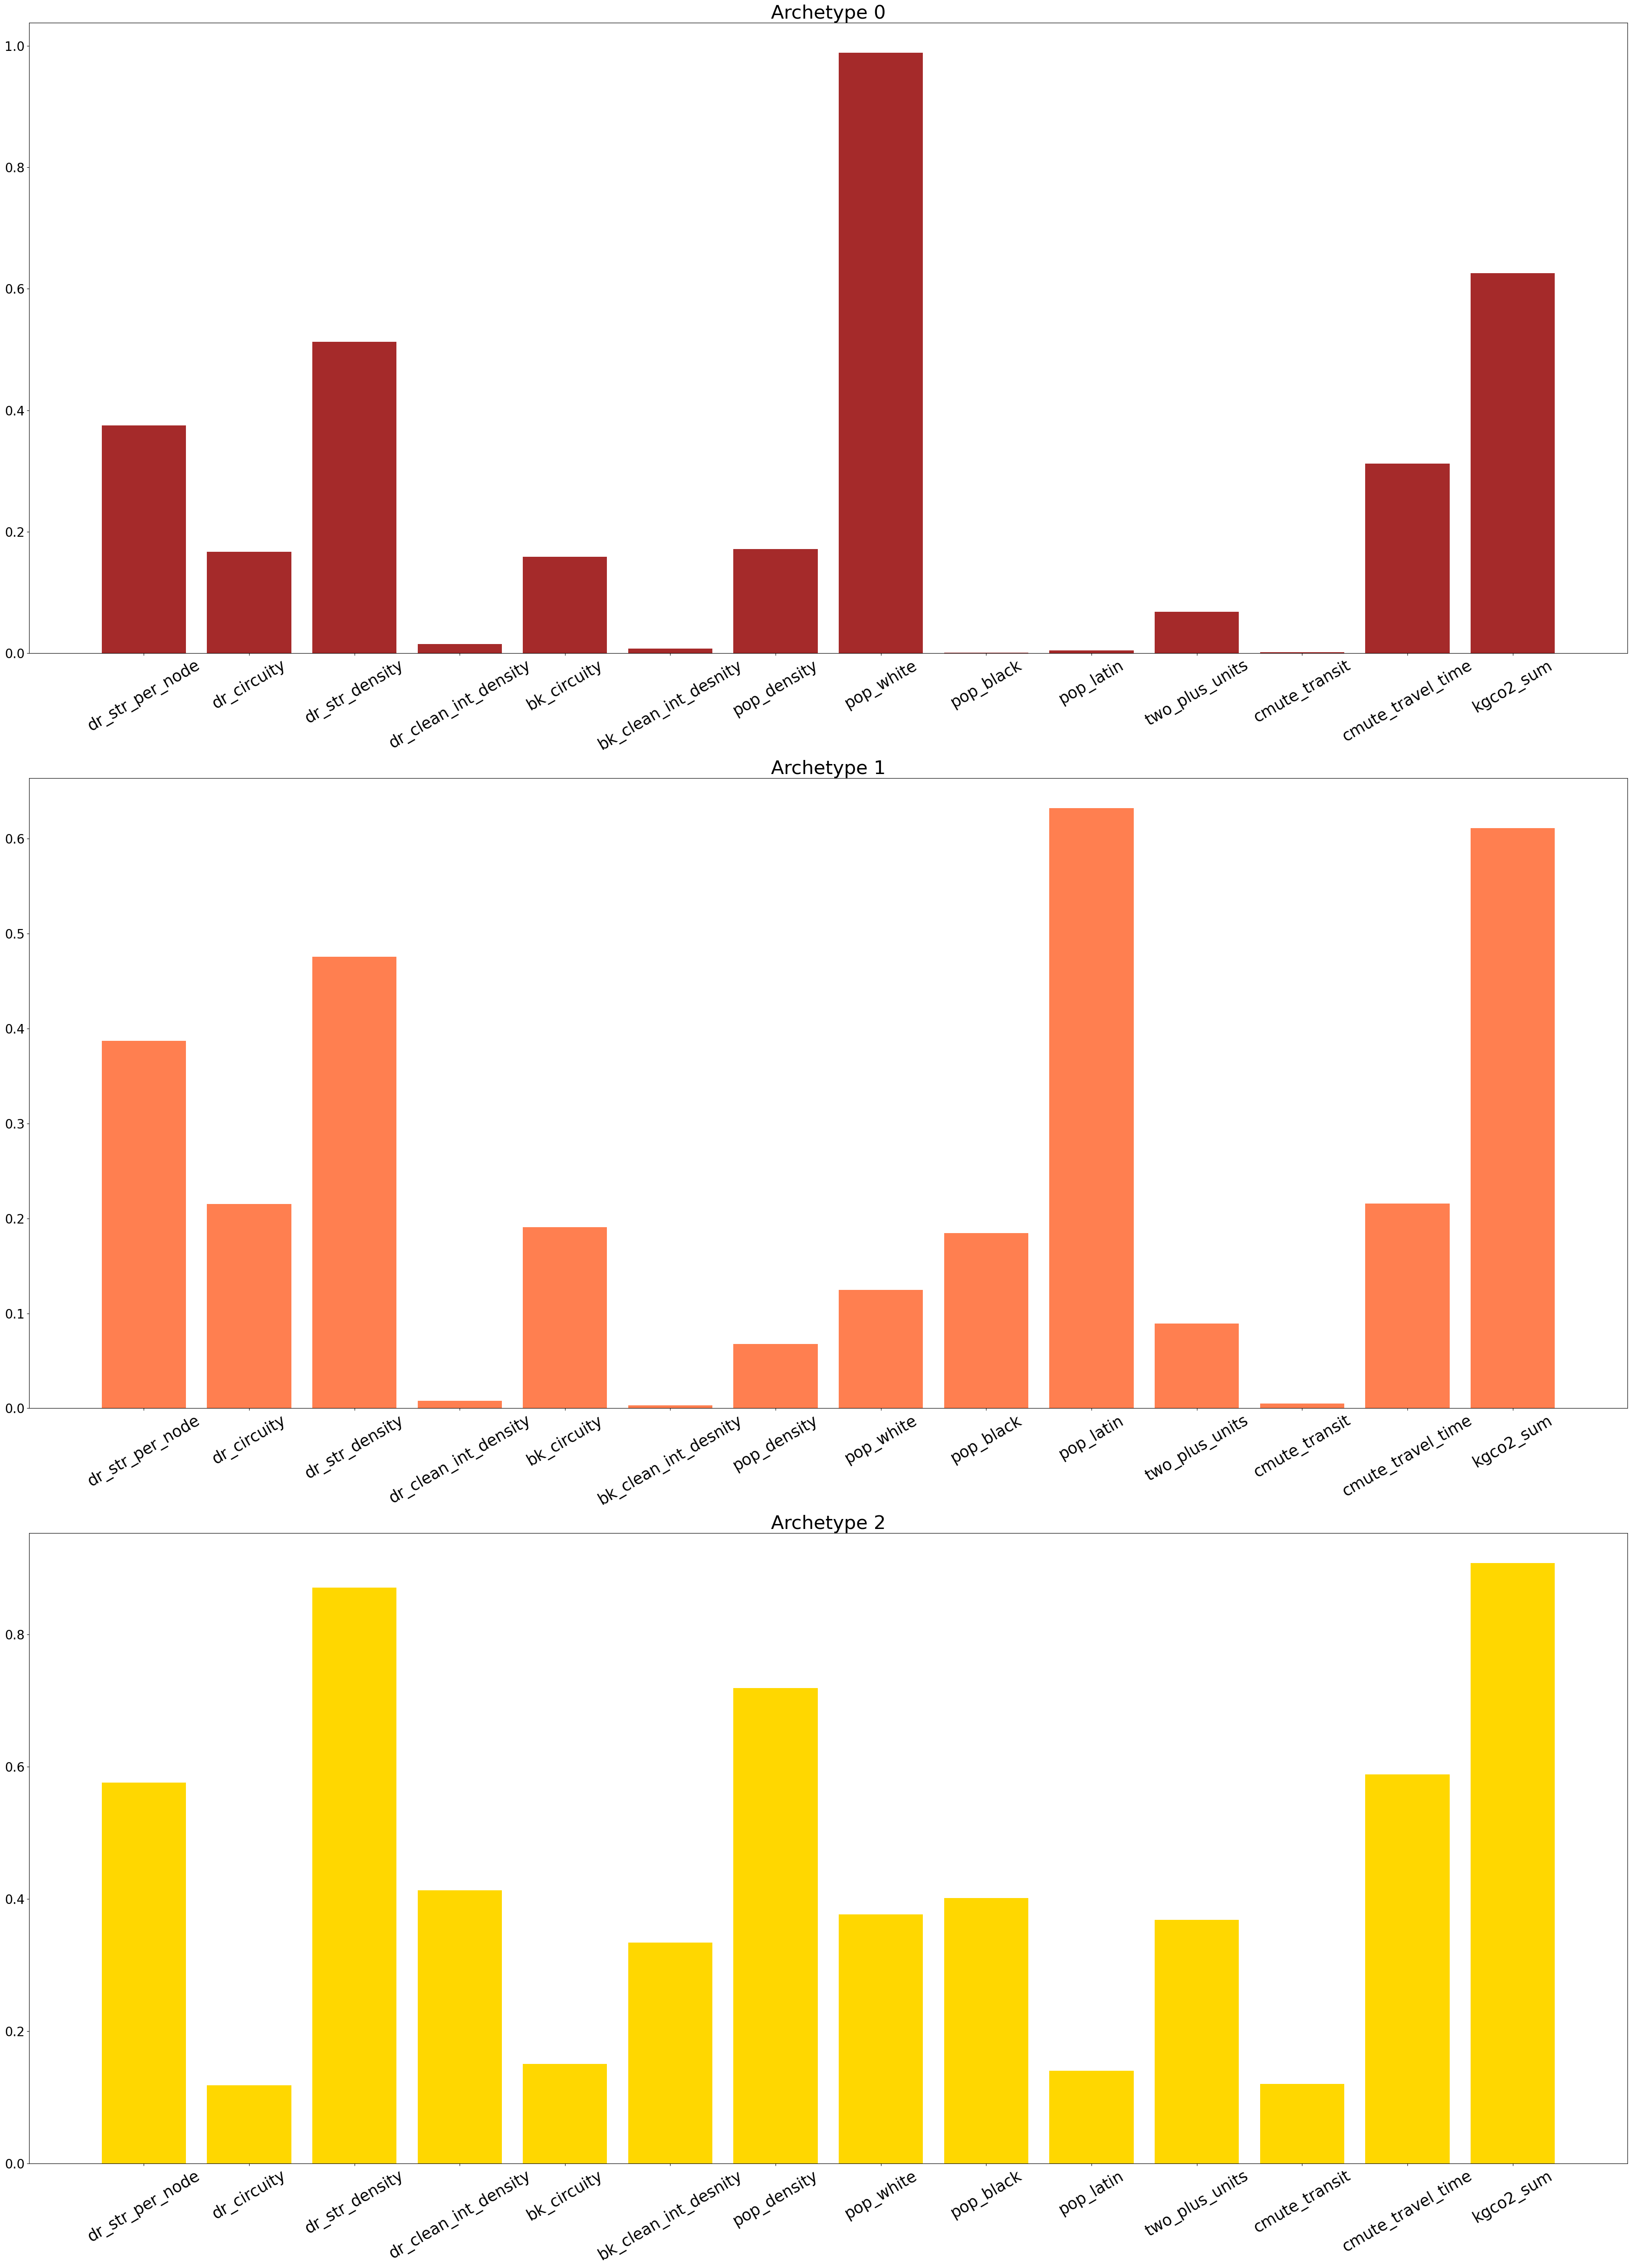

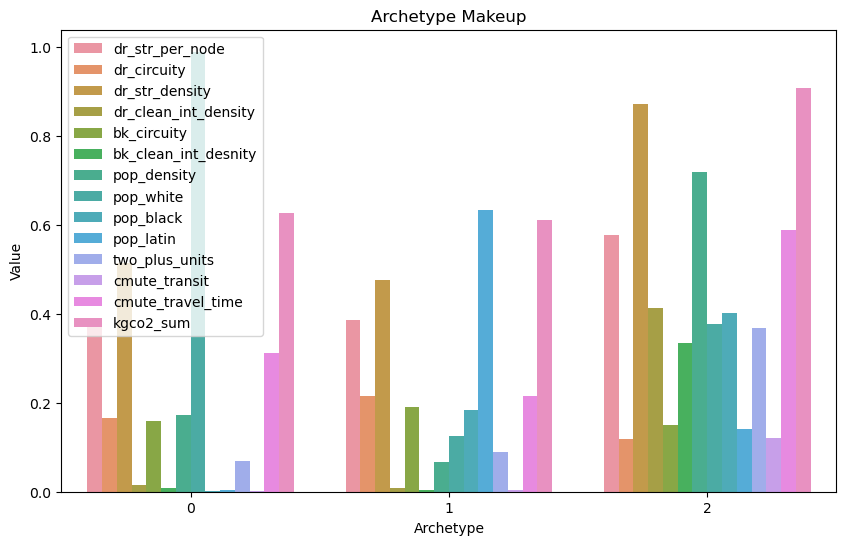

In [126]:
reduced_reduced_df = reduced_df.drop(columns=['bk_dr_ratio',
                                              'bk_str_density',
                                              'bk_str_per_node',
                                              'edu_bachelor',
                                              'hh_income_median',
                                              'cmute_carpool',
                                              'cmute_work_in_county',
                                              'no_vehicle',
                                              'area_sqkm']
                                              )

rr_D = reduced_reduced_df.to_numpy()

# Train Model with 3 Archetypes
model = arch.AA(n_archetypes=3, n_init=10, max_iter=10_000, tol=1e-16, random_state=0)
model.fit(rr_D)

# build DF of resulting archetypes
arch_df_3 = pd.DataFrame(model.archetypes_, columns=reduced_reduced_df.columns)
plot_horizontal_archetypes_bar(arch_df_3, 3)
plot_vertical_archetypes_bar(arch_df_3)

/Users/erin/anaconda3/lib/python3.11/site-packages/archetypes/visualization/simplex.py:146: RuntimeWarning: invalid value encountered in divide
  projections /= np.linalg.norm(projections, axis=1)[:, None]


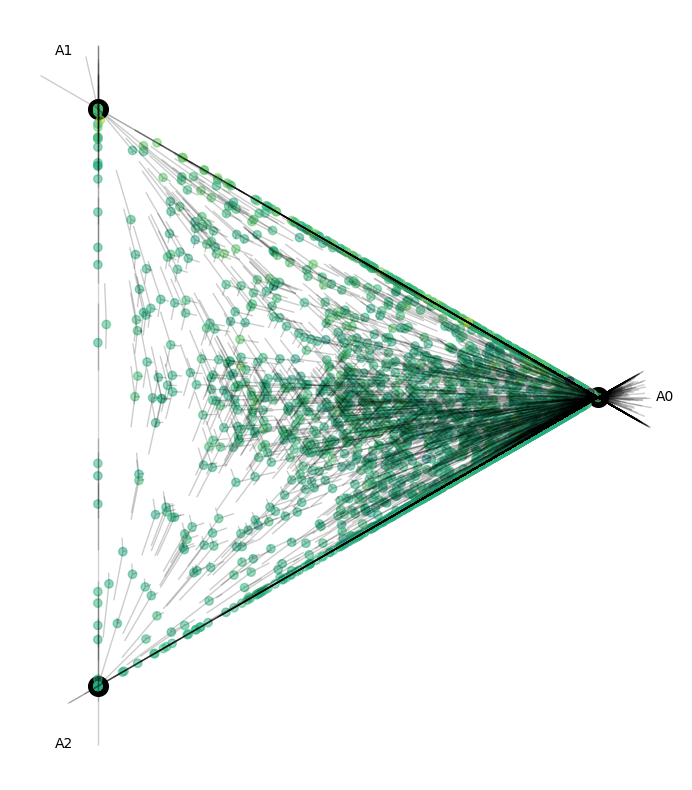

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
arch.simplex(model.alphas_, c=target, alpha=0.5, show_circle=False, show_direction=True)

plt.show()